In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf4
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from cftime import DatetimeNoLeap
import datetime as dt

from sklearn.metrics.pairwise import euclidean_distances, haversine_distances
import metpy as mp

In [2]:
def read_tempest(file, colnames):
    
    # Reads in file
    df = pd.read_csv(file, sep='\s+', names=colnames)
    
    # Takes individual year, month, day, hour columns and transforms to pd.date_time column
    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], errors='coerce')
    
    # Drops year, month, day, hour columns
    df = df[['time', 'lon_x', 'lat_y', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']]
    
    # Selects indices where a new track starts, assigns to array
    run_idx = df[df.lon_x=='start'].index.tolist()
    
    # Quantifies the max number of timesteps for all tracks
    max_tsteps = df['lat_y'].iloc[run_idx].values.max()

    # Separates dataframe into individual dataframes, split on new tracks
    dfs = [df.iloc[run_idx[n]+1:run_idx[n+1]] for n in range(len(run_idx)-1)]
    
    # Drops lon_x and lat_y columns
    dfs = [dfi[['time', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi']] for dfi in dfs]
    
    # Resets index from previous dataframe splits
    dfs = [dfi.reset_index(drop=True) for dfi in dfs]
    
    # Pads dataframes with NaN rows so they're all the same length as the longest dataframe
    dfs = [dfi.reindex(range((max_tsteps-len(dfi))+len(dfi))) for dfi in dfs]
    
    # Converts longitude from [0, 360] to [-180, 180] 
    for dfi in dfs:
        dfi['lon'] = dfi['lon'].map(lambda x: np.mod((x+180), 360)-180)
        
    # Makes sure lat, lon, wsp, slp, phi columns are floats and not str
    #for dfi
    
    return dfs

In [3]:
def calc_distance(x, y, method, radius=6371):
    """
    method = 'euclidean or haversine'
    radius is in km"""
    
    
    
    if method == 'euclidean' or method == 'Euclidean':
        
    elif method == 'haversine' or method == 'Haversine':
        
    else:
        print("Pick 'euclidean' or 'haversine' as the method.")

IndentationError: expected an indented block (1019680463.py, line 10)

In [4]:
ERA5 = r"~/tempest-scripts/trajectories.txt.ERA5"
colnames = ['lon_x', 'lat_y', 'lon', 'lat', 'slp', 'wsp', 'sfc_phi', 'year', 'month', 'day', 'hour']
# sfc_phi = 0 over ocean, >10 over land0
ERA5_dfs = read_tempest(ERA5, colnames)

In [5]:
ERA5_dfs[-1]

,time,lon,lat,slp,wsp,sfc_phi
0,2018-12-23 06:00:00,142.00,6.25,100137.90,13.06645,0.0
1,2018-12-24 00:00:00,137.75,7.25,100383.80,12.50708,0.0
2,2018-12-24 06:00:00,137.25,7.50,99984.75,12.30545,0.0
3,2018-12-24 12:00:00,136.50,7.25,100349.80,12.87230,0.0
4,2018-12-24 18:00:00,136.00,7.50,100170.20,11.46944,0.0
...,...,...,...,...,...,...
102,NaT,NaN,NaN,NaN,NaN,NaN
103,NaT,NaN,NaN,NaN,NaN,NaN
104,NaT,NaN,NaN,NaN,NaN,NaN
105,NaT,NaN,NaN,NaN,NaN,NaN


In [13]:
ERA5_dfs[0].time.values[0]

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [6]:
# These are all the correct shape/consistent with IBTRACS data
ERA5_data = np.stack([df.values for df in ERA5_dfs])
date_time = np.dstack([df['time'].values for df in ERA5_dfs])[0]
#time = ERA5_data[:,:,0].astype()
time = np.stack([df['time'].values for df in ERA5_dfs])
lon = ERA5_data[:,:,1].astype(float)
lat = ERA5_data[:,:,2].astype(float)
slp = ERA5_data[:,:,3].astype(float)
wsp = ERA5_data[:,:,4].astype(float)
szn = np.hstack([np.datetime_as_string(df['time'].values[0], 'Y')\
           for df in ERA5_dfs]).astype(float)
#sid = 

In [7]:
# Write attributes/data descriptions later
ERA5_ds = xr.Dataset(
        data_vars=dict(
            pressure=(['storm', 'date_time'], slp, {'units':'Pa'}),
            wind_speed=(['storm', 'date_time'], wsp, {'units':'m/s'})),
        coords=dict(
            time=(['storm', 'date_time'], time),
            lon=(['storm', 'date_time'], lon),
            lat=(['storm', 'date_time'], lat)))
ERA5_ds

<xarray.Dataset>
Dimensions:     (storm: 3084, date_time: 107)
Coordinates:
    time        (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon         (storm, date_time) float64 120.5 119.0 119.0 ... nan nan nan
    lat         (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 9.988e+04 9.981e+04 ... nan nan
    wind_speed  (storm, date_time) float64 14.65 13.99 13.7 ... nan nan nan

In [17]:
ERA5_ds.isel(date_time=np.datetime64('1980-01-06T06:00:00.000000000'), method='nearest')

ValueError: Dimensions {'method'} do not exist. Expected one or more of Frozen({'storm': 3084, 'date_time': 107})

In [8]:
ERA5_ds.isel(storm=0)

<xarray.Dataset>
Dimensions:     (date_time: 107)
Coordinates:
    time        (date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon         (date_time) float64 120.5 119.0 119.0 119.2 ... nan nan nan nan
    lat         (date_time) float64 -14.25 -14.75 -15.0 -15.0 ... nan nan nan
Dimensions without coordinates: date_time
Data variables:
    pressure    (date_time) float64 9.988e+04 9.981e+04 9.954e+04 ... nan nan
    wind_speed  (date_time) float64 14.65 13.99 13.7 17.98 ... nan nan nan nan

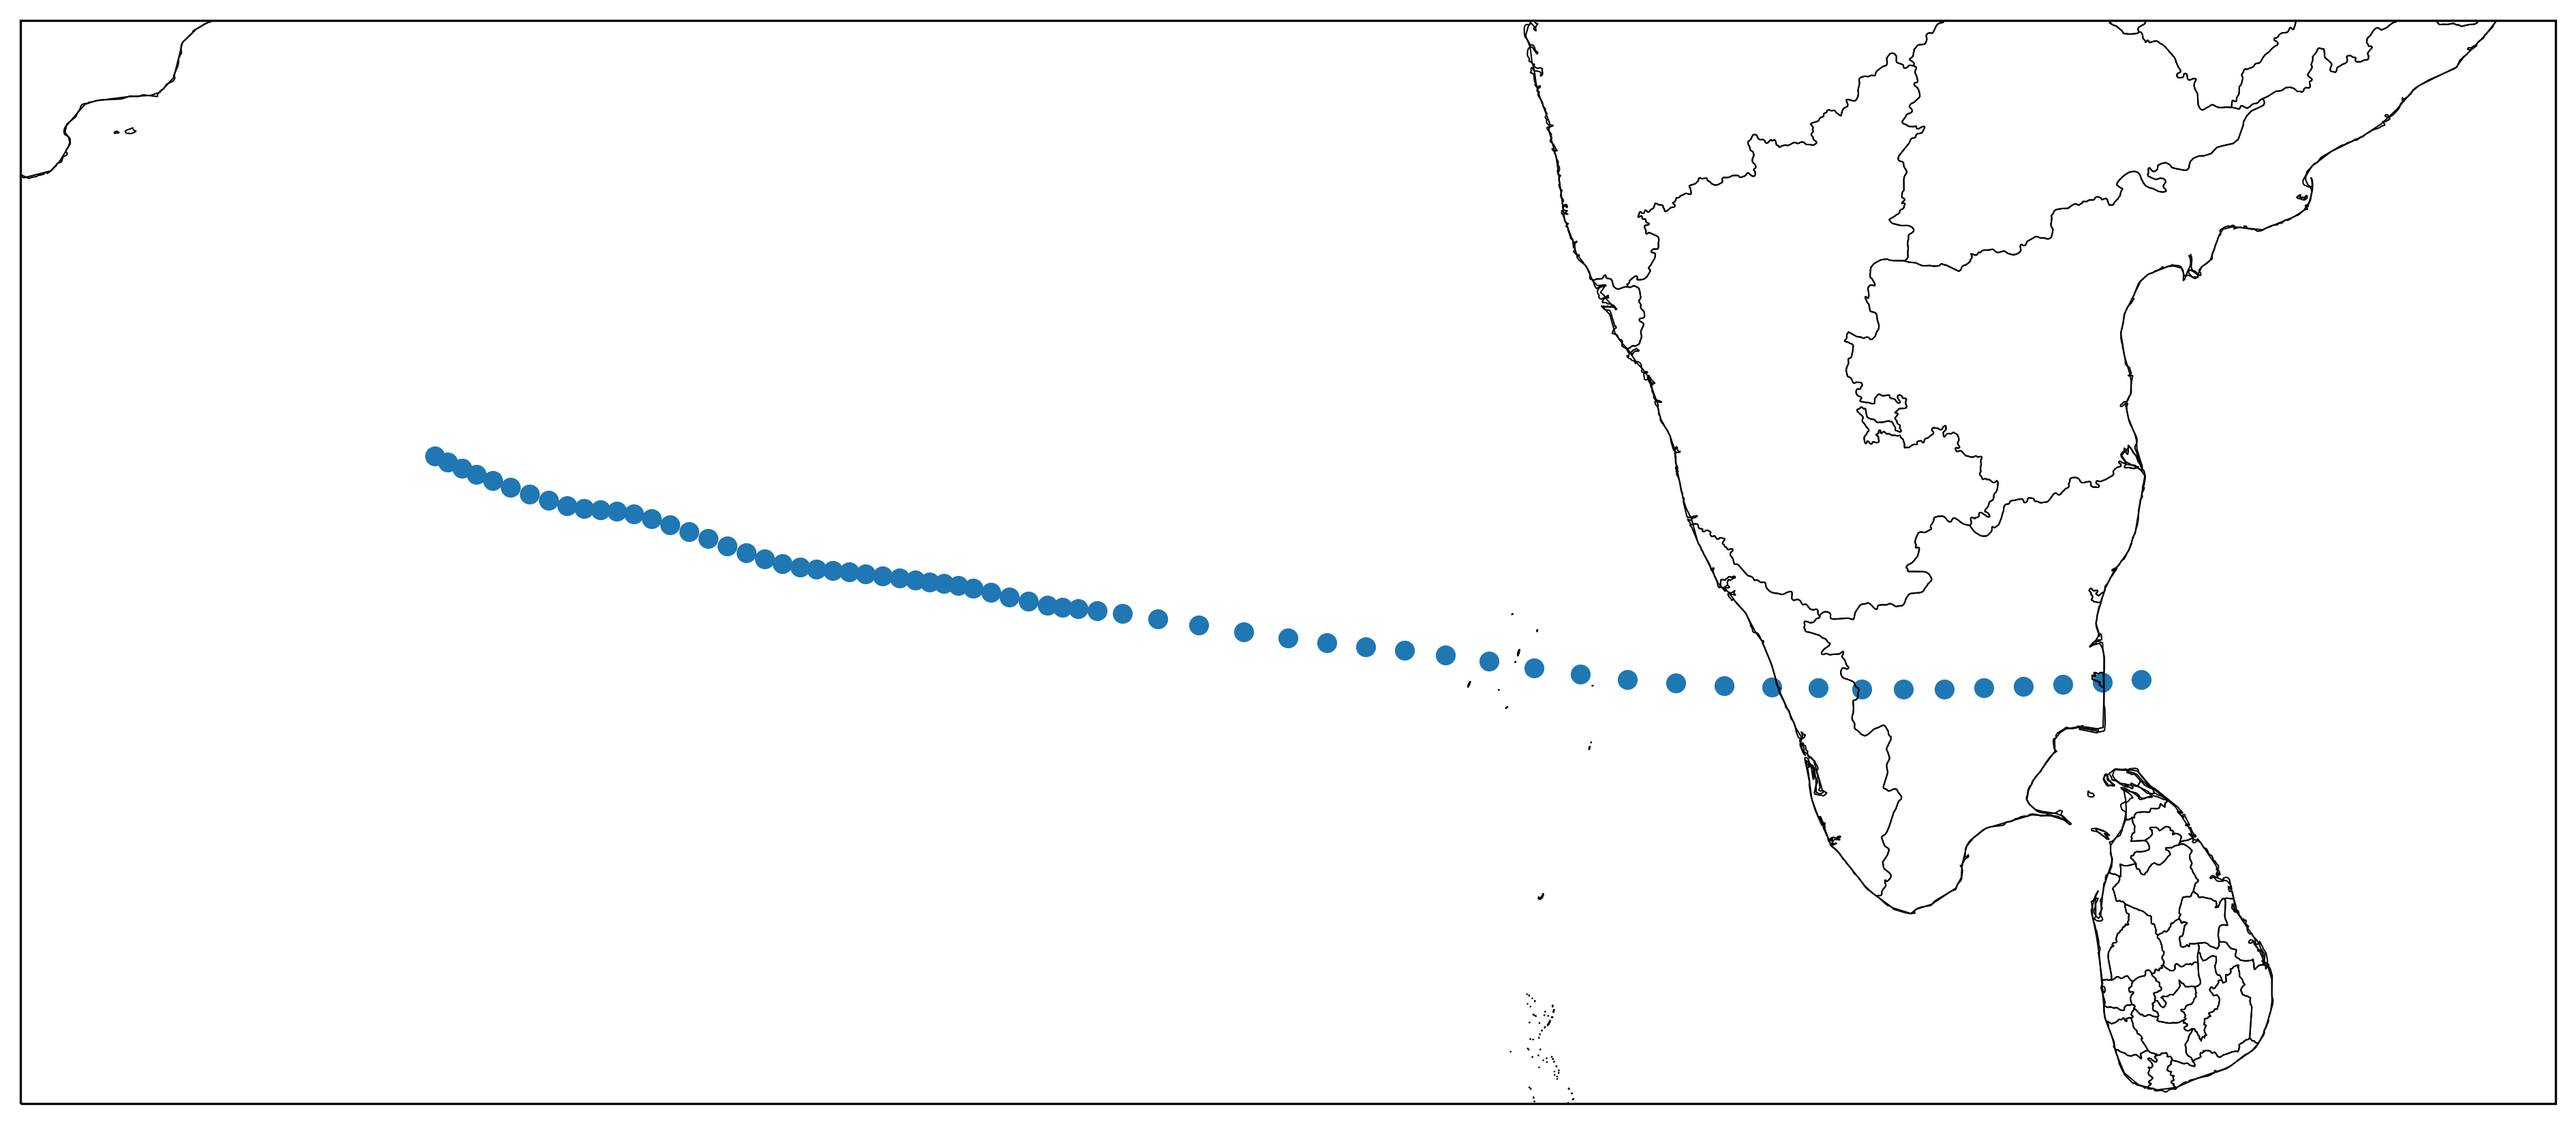

In [42]:
def plot_background(xmin, xmax, ymin, ymax, ax):
    ax.set_extent([xmin-5, xmax+5, ymin-5, ymax+5])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

data = ibtracs_ds.isel(storm=0)
lats = data.lat.values
lons = data.lon.values

# Set up figure, basemap, etc.
proj=ccrs.PlateCarree(globe=None)
fig, ax = plt.subplots(figsize=(16,12), dpi=300, subplot_kw=dict(projection=proj))
plot_background(min(lons), max(lons), min(lats), max(lats), ax)

data.plot.scatter(x='lon', y='lat', transform=proj, ax=ax)
plt.show()

In [18]:
# Create function to index by storm (slice by lat/lon bounds, datetime, etc.)
# Colin's idea: pick out storm from ibtracs and use that to index tempest extremes 
# (possibly by using min slp for lat/lon bounding box)

# Read in ibtracs data

# Plot difference in storms (try to make sure translation speed is well represented)

In [10]:
ibtracs = r"~/tempest-scripts/IBTrACS.ALL.v04r00.nc"

In [11]:
ibtracs_ds = xr.open_dataset(ibtracs).load()
ibtracs_ds

<xarray.Dataset>
Dimensions:           (storm: 13607, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1842-10-25T03:00:00.0...
    lat               (storm, date_time) float32 10.9 10.87 10.84 ... nan nan
    lon               (storm, date_time) float32 80.3 79.83 79.35 ... nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 65.0 25.0 49.0 89.0 ... 29.0 47.0 45.0
    sid               (storm) |S13 b'1842298N11080' ... b'2022083S13076'
    season            (storm) float32 1.842e+03 1.845e+03 ... 2.022e+03
    number            (storm) int16 1 1 1 2 3 4 5 6 ... 12 13 14 15 16 17 18 19
    basin             (storm, date_time) |S2 b'NI' b'NI' b'NI' ... b'' b'' b''
    subbasin          (storm, date_time) |S2 b'BB' b'BB' b'BB' ... b'' b'' b''
    ...                ...
    reunion_gust      (storm, date_time) float32 nan nan nan nan ... nan nan nan
    reunion_gust_per  (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_seahgt        (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_searad        (storm, date_time, quadrant) float32 nan nan ... nan nan
    storm_speed       (storm, date_time) float32 9.0 9.0 9.0 9.0 ... nan nan nan
    storm_dir         (storm, date_time) float32 266.0 267.0 267.0 ... nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [ ]:
ibtracs_ds.sel(date_time = ibtracs_ds. == 'L30')

In [375]:
katrina = ibtracs_ds.where(((ibtracs_ds.name==b'KATRINA') &\
                            (ibtracs_ds.season==2005)), drop=True)
katrina = katrina.sel(storm=[0])

In [104]:
ibtracs_ds['lon'].values.shape

# date_time is dimension of max timesteps per storm

(13607, 360)

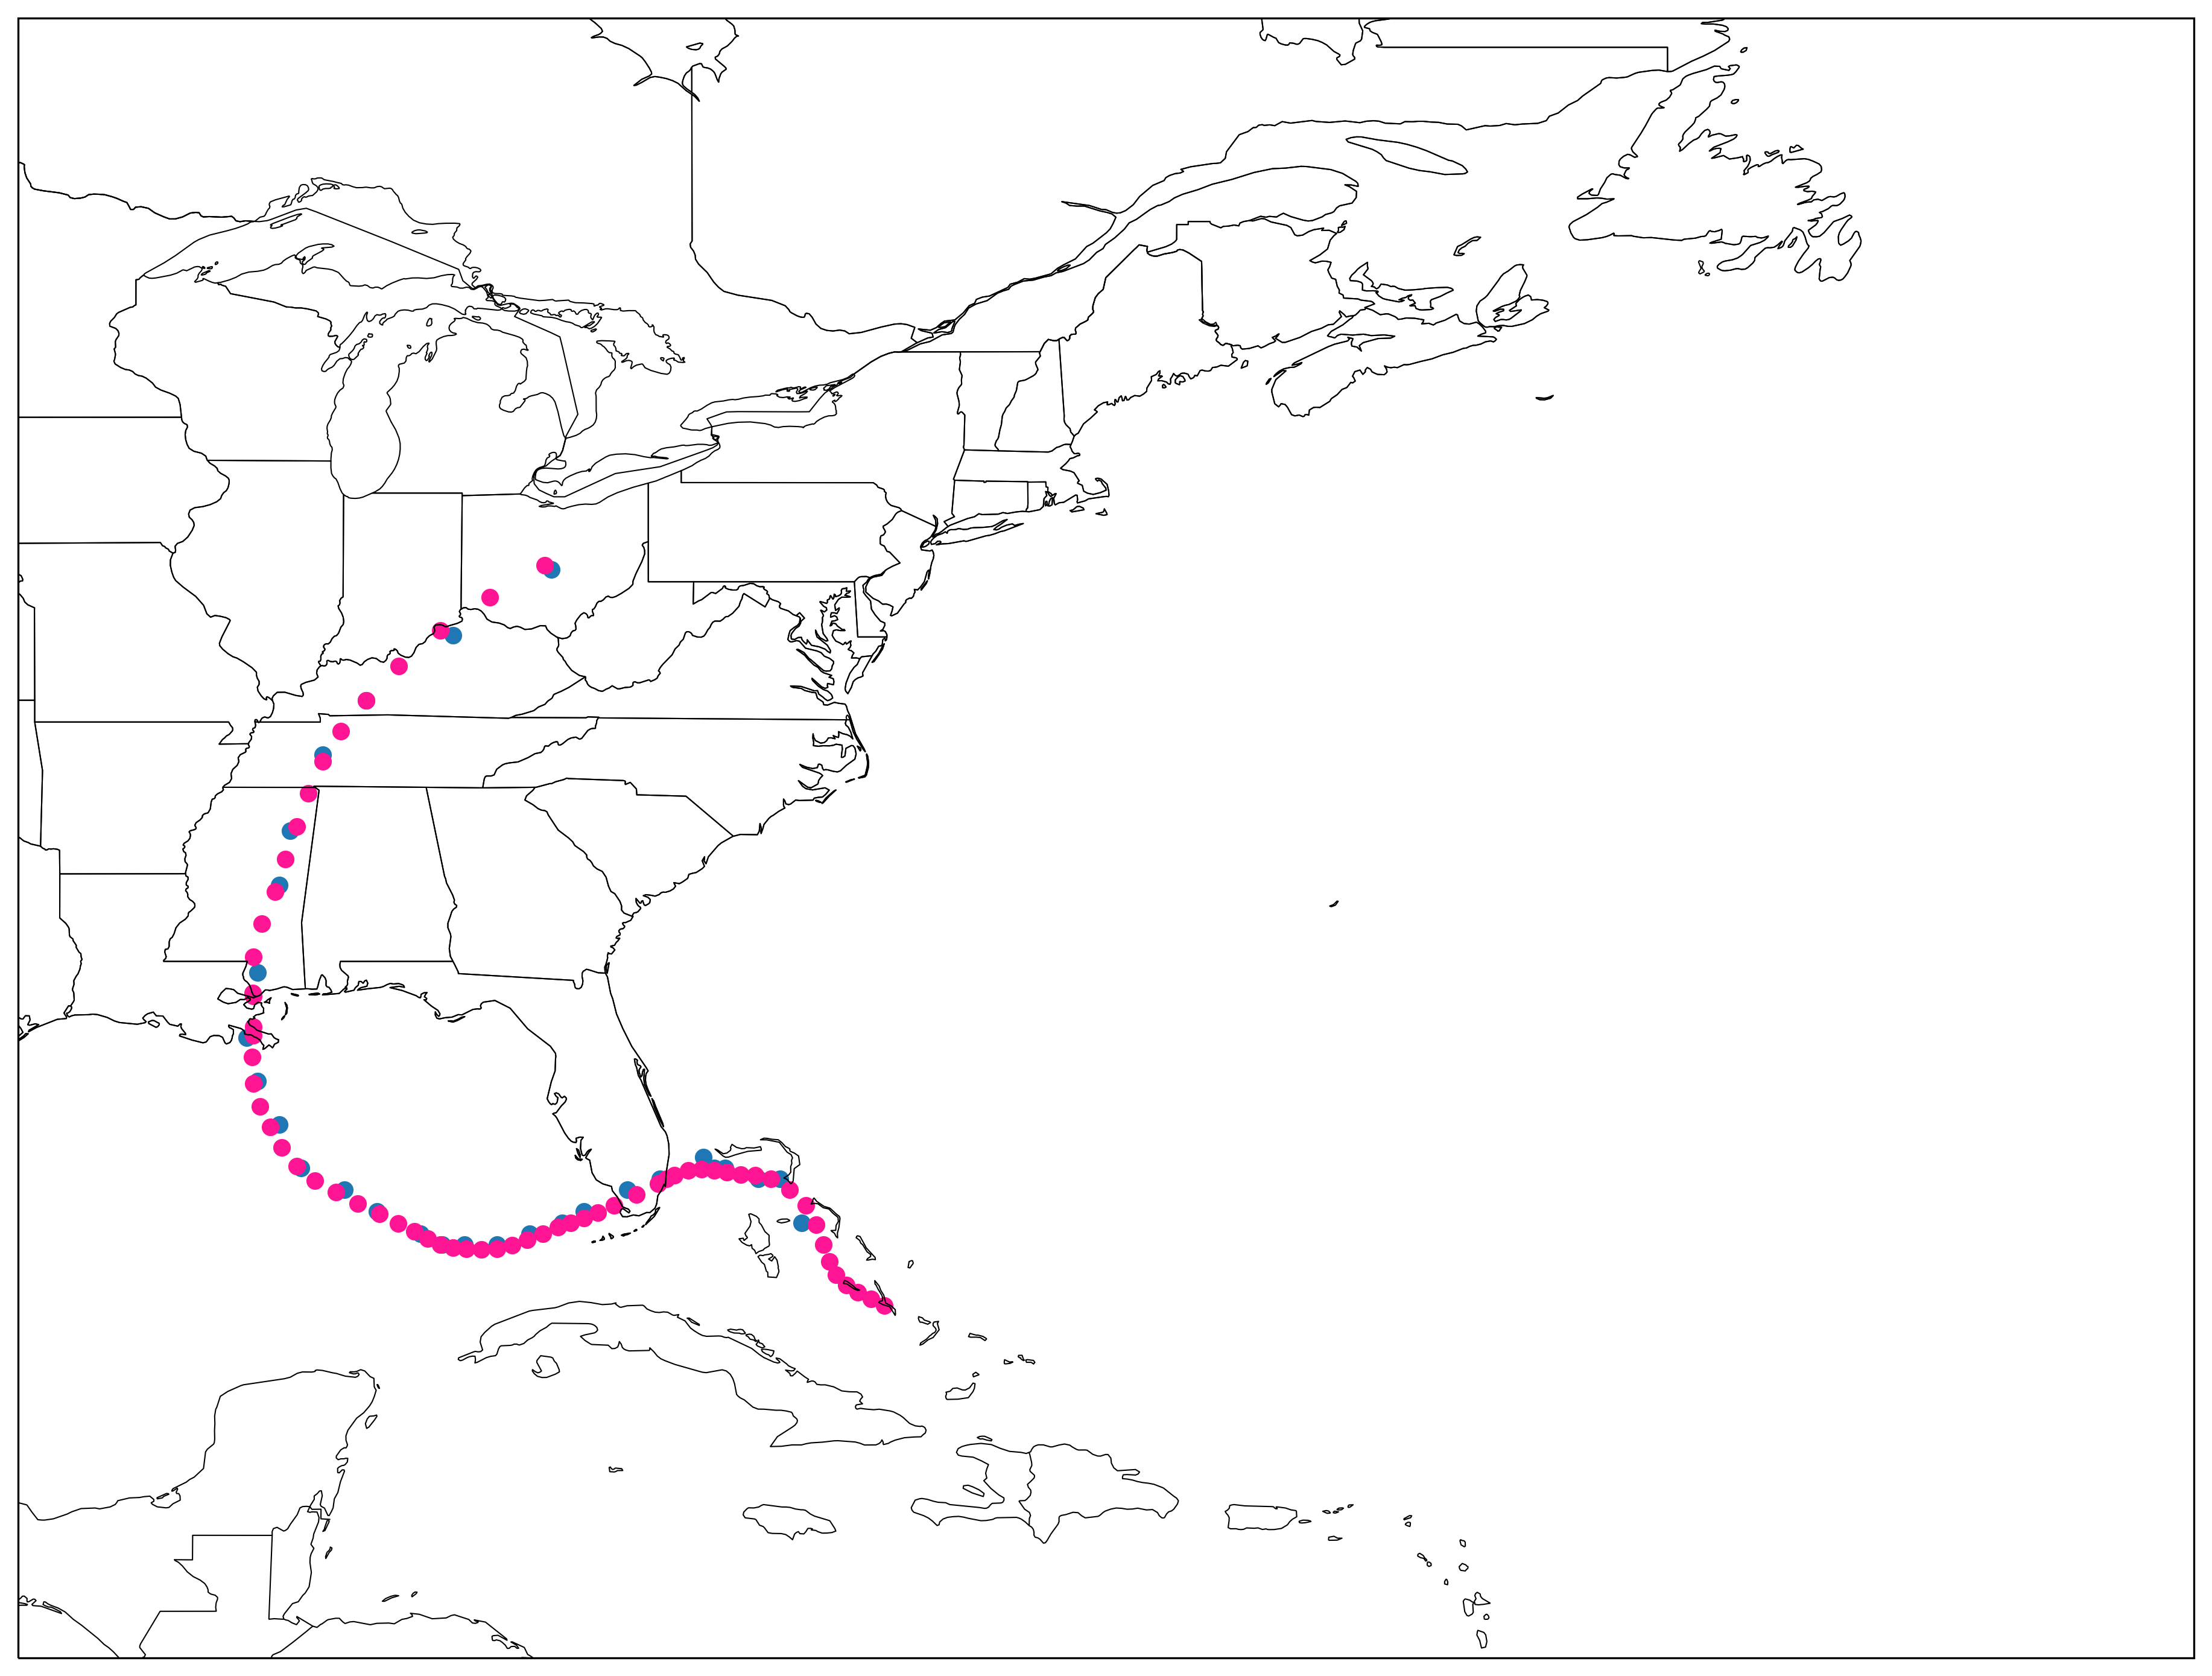

In [388]:
def plot_background(ax):
    ax.set_extent([265., 315., 15., 50.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

# Set up figure, basemap, etc.
fig = plt.figure(figsize=(16, 12), dpi=300)
proj=ccrs.PlateCarree(globe=None)
ax = fig.add_subplot(1,1,1,projection=proj)
plot_background(ax)

subset = ERA5_ds.where(((ERA5_ds.time.dt.year==2005) &\
                               (ERA5_ds.time.dt.month==8)), drop=True)
i=9
subset.sel(storm=[i]).plot.scatter('lon', 'lat', transform=proj)
katrina.plot.scatter('lon', 'lat', transform=proj, color='deeppink')

plt.show()

In [348]:
subset['lon'].sel(storm=[i]).plot

In [105]:
ERA5_ds['pressure'].time.dt.year

<xarray.DataArray 'year' (storm: 3084, date_time: 107)>
array([[1980., 1980., 1980., ...,   nan,   nan,   nan],
       [1980., 1980., 1980., ...,   nan,   nan,   nan],
       [1980., 1980., 1980., ...,   nan,   nan,   nan],
       ...,
       [2018., 2018., 2018., ...,   nan,   nan,   nan],
       [2018., 2018., 2018., ...,   nan,   nan,   nan],
       [2018., 2018., 2018., ...,   nan,   nan,   nan]])
Coordinates:
    time     (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon      (storm, date_time) float64 120.5 119.0 119.0 119.2 ... nan nan nan
    lat      (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time

In [257]:
ERA5_ds['time'][0].values[0] == np.datetime64('1980-01-06')

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [259]:
np.datetime64('1980-01-06') == datetime(1980,1,6)

False

In [175]:
ERA5_ds['time'][0].values[0].astype('datetime64[ns]')

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [173]:
ERA5_ds['time'][0].values[0]

numpy.datetime64('1980-01-06T06:00:00.000000000')

In [177]:
np.datetime64('1980-08').astype('datetime64[ns]')

numpy.datetime64('1980-08-01T00:00:00.000000000')

In [239]:
ERA5_ds['pressure'].isel(time='2011')

ValueError: Dimensions {'time'} do not exist. Expected one or more of Frozen({'storm': 3084, 'date_time': 107})

In [241]:
ERA5_ds.time.dt.year == 2012

<xarray.DataArray 'year' (storm: 3084, date_time: 107)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon      (storm, date_time) float64 120.5 119.0 119.0 119.2 ... nan nan nan
    lat      (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time

In [243]:
ERA5_ds.sel(ERA5_ds.coords['time'] == '2011')

ValueError: the first argument to .sel must be a dictionary

In [ ]:
def ibtracs_date_indexing(start, end=None):
    if type(start) == int and len(start) == 4:
        print(f'Indexing by year: {start}')
    elif type(start) == tuple:
        print(f'Indexing by year: {start[0]}, month: {start[1]}')

In [267]:
(2018,1,10)[0]

2018

In [307]:
ERA5_ds.sel(time=slice('2011', '2012'))

KeyError: 'no index found for coordinate time'

In [304]:
ERA5_dt = ERA5_ds.time.dt


test = ERA5_ds.where(((ERA5_dt.year==2005) & (ERA5_dt.month==8)), 
                      drop=True)
test

<xarray.Dataset>
Dimensions:     (storm: 14, date_time: 38)
Coordinates:
    time        (storm, date_time) datetime64[ns] 2005-07-28T06:00:00 ... 200...
    lon         (storm, date_time) float64 113.0 113.2 113.2 ... -39.25 -38.0
    lat         (storm, date_time) float64 18.5 17.75 18.5 ... 41.75 43.0 44.25
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 nan nan nan nan ... nan nan nan nan
    wind_speed  (storm, date_time) float64 nan nan nan nan ... nan nan nan nan

In [275]:
ERA5_ds

<xarray.Dataset>
Dimensions:     (storm: 3084, date_time: 107)
Coordinates:
    time        (storm, date_time) datetime64[ns] 1980-01-06T06:00:00 ... NaT
    lon         (storm, date_time) float64 120.5 119.0 119.0 ... nan nan nan
    lat         (storm, date_time) float64 -14.25 -14.75 -15.0 ... nan nan nan
Dimensions without coordinates: storm, date_time
Data variables:
    pressure    (storm, date_time) float64 9.988e+04 9.981e+04 ... nan nan
    wind_speed  (storm, date_time) float64 14.65 13.99 13.7 ... nan nan nan

In [254]:
datetime(2011, 12, 25)

datetime.datetime(2011, 12, 25, 0, 0)